In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(5)

def price_elast(price, temp, weekday, cost):
    return  -4 + 0.2*price + 0.05*temp + 2*np.isin(weekday, [1,7]) + 0.3 * cost

def sales(price, temp, weekday, cost):
    elast = -abs(price_elast(price, temp, weekday, cost))
    output = np.random.normal(200 + 20*np.isin(weekday, [1,7]) + 1.3 * temp +
                              5*elast * price, 5).astype(int)
    
    return output


n_rnd = 5000

temp = np.random.normal(24, 4, n_rnd).round(1)
weekday = np.random.choice(list(range(1, 8)), n_rnd)
cost = np.random.choice([0.3, 0.5, 1.0, 1.5], n_rnd)
price_rnd = np.random.choice(list(range(3, 11)), n_rnd)

price_df_rnd = pd.DataFrame(dict(temp=temp, weekday=weekday, cost=cost,
                                 price=price_rnd, sales=sales(price_rnd, temp, weekday, cost)))

n = 10000
temp = np.random.normal(24, 4, n).round(1)
weekday = np.random.choice(list(range(1, 8)), n)
cost = np.random.choice([0.3, 0.5, 1.0, 1.5], n)
price = np.random.normal(5 + cost + np.isin(weekday, [1,7])).round(1)

price_df = pd.DataFrame(dict(temp=temp, weekday=weekday, cost=cost,
                             price=price, sales=sales(price, temp, weekday, cost)))


OSError: Cannot save file into a non-existent directory: 'causal-inference-for-the-brave-and-true/data'

In [2]:
price_df_rnd.to_csv("ice_cream_sales_rnd.csv", index=False)
price_df.to_csv("ice_cream_sales.csv", index=False)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

In [3]:
test = pd.read_csv("ice_cream_sales_rnd.csv")
train = pd.read_csv("ice_cream_sales.csv")
train.head()


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


<Axes: xlabel='price', ylabel='sales'>

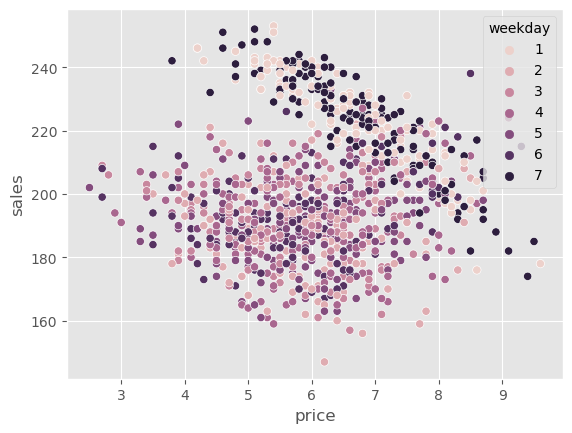

In [6]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

Through visualization, it is clear that on the weekend (weekday=1 and 7), 

the price is much higher than usual, that is, there is confusion.

In this dataset, feature X includes three variables: 

    temperature, cost and day of the week, Treatment T is price, and outcome Y is sales volume.
    
    Where T affects Y and X affects T and Y, there is confusion.

ATE

In [8]:
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

In [9]:
smf.ols("sales_res~price_res", 
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.364e-13,0.111,-4.85e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


We’ve estimated the ATE to -4, meaning that each unit increase in price will lower sales by 4 units.

CATE

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 